# Diplomacy Lie Detection - Baseline Model

This notebook implements a baseline model for the Diplomacy lie detection task based on the 2020 ACL Diplomacy project. We'll use a Bag of Words approach with Logistic Regression, which provides a solid baseline for text classification tasks.

## Setup and Imports

In [17]:
# Import required libraries
import jsonlines
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import csr_matrix
import spacy
from spacy.lang.en import English
import warnings
warnings.filterwarnings("ignore")

In [18]:
# Initialize spaCy for tokenization
try:
    nlp = English()
    print("SpaCy English model loaded successfully.")
except Exception as e:
    print(f"Error loading spaCy English model: {e}")
    print("Try installing with: python -m spacy download en_core_web_sm")

SpaCy English model loaded successfully.


## Define Helper Functions

In [19]:
# Define tokenizer function that converts numbers to a special token
def is_number(tok):
    try:
        float(tok)
        return True
    except ValueError:
        return False

def spacy_tokenizer(text):
    return [tok.text if not is_number(tok.text) else '_NUM_' for tok in nlp(text)]

In [20]:
# Function to aggregate data from dialogues into individual messages
def aggregate(dataset):
    messages = []
    rec = []
    send = []
    power = []
    for dialogs in dataset:
        messages.extend(dialogs['messages'])
        rec.extend(dialogs['receiver_labels'])
        send.extend(dialogs['sender_labels'])
        power.extend(dialogs['game_score_delta'])
    
    merged = []
    for i, item in enumerate(messages):
        merged.append({
            'message': item, 
            'sender_annotation': send[i], 
            'receiver_annotation': rec[i], 
            'score_delta': int(power[i])
        })
    return merged

In [21]:
# Convert annotations to binary labels
def convert_to_binary(dataset, task="SENDER", use_power=True):
    binary_data = []
    
    for message in dataset:
        # Skip unannotated instances for RECEIVER task
        if message['receiver_annotation'] != True and message['receiver_annotation'] != False:
            if task == "SENDER":
                pass  # Keep all for SENDER task
            elif task == "RECEIVER":
                continue  # Skip for RECEIVER task
            
        binary = []
        
        # Add power features if enabled (severe power skew)
        if use_power:
            # Strong positive power delta
            if message['score_delta'] > 4:
                binary.append(1)
            else:
                binary.append(0)
            
            # Strong negative power delta
            if message['score_delta'] < -4:
                binary.append(1)
            else:
                binary.append(0)

        # Get annotation based on task
        if task == "SENDER":
            annotation = 'sender_annotation'
        elif task == "RECEIVER":
            annotation = 'receiver_annotation'
            
        # Add class label
        if message[annotation] == False:
            binary.append(0)  # 0 for False (lie)
        else:
            binary.append(1)  # 1 for True (truth)

        binary_data.append(binary)
    return binary_data

In [22]:
# Split data into features (X) and labels (y)
def split_xy(data):
    X, y = [], []
    for line in data:
        x = line[:len(line)-1]
        single_y = line[len(line)-1]
        X.append(x)
        y.append(single_y)
    return (X, y)

## Load Data

Make sure to place the train.jsonl and test.jsonl files in a 'data/' directory.

In [23]:
# Set data path and load data
data_path = 'Data/'  # Adjust this path as needed

try:
    with jsonlines.open(data_path+'train.jsonl', 'r') as reader:
        train_data = list(reader)
    with jsonlines.open(data_path+'test.jsonl', 'r') as reader:
        test_data = list(reader)
    
    print(f"Successfully loaded {len(train_data)} training dialogues and {len(test_data)} test dialogues.")
except Exception as e:
    print(f"Error loading data: {e}")
    print("Please make sure the data files (train.jsonl and test.jsonl) are in the 'data/' directory.")

Successfully loaded 189 training dialogues and 42 test dialogues.


## Examine Data Sample

In [24]:
# Display an example from the dataset
print("Example dialogue:")
print(f"Number of messages: {len(train_data[0]['messages'])}")
for i, msg in enumerate(train_data[0]['messages'][:3]):
    print(f"\nMessage {i+1}: {msg}")
    print(f"Sender label: {train_data[0]['sender_labels'][i]}")
    print(f"Receiver label: {train_data[0]['receiver_labels'][i]}")
    print(f"Power score delta: {train_data[0]['game_score_delta'][i]}")

Example dialogue:
Number of messages: 321

Message 1: Germany!

Just the person I want to speak with. I have a somewhat crazy idea that I’ve always wanted to try with I/G, but I’ve never actually convinced the other guy to try it. And, what’s worse, it might make you suspicious of me. 

So...do I suggest it?

I’m thinking that this is a low stakes game, not a tournament or anything, and an interesting and unusual move set might make it more fun? That’s my hope anyway.

What is your appetite like for unusual and crazy?
Sender label: True
Receiver label: True
Power score delta: 0

Message 2: You've whet my appetite, Italy. What's the suggestion?
Sender label: True
Receiver label: True
Power score delta: 0

Message 3: 👍
Sender label: True
Receiver label: True
Power score delta: 0


## Class Distribution Analysis

Sender annotations:
Truth: 12541 (95.5%)
Lie: 591 (4.5%)
No annotation: 0

Receiver annotations:
Truth: 11459 (95.3%)
Lie: 566 (4.7%)
No annotation: 1107


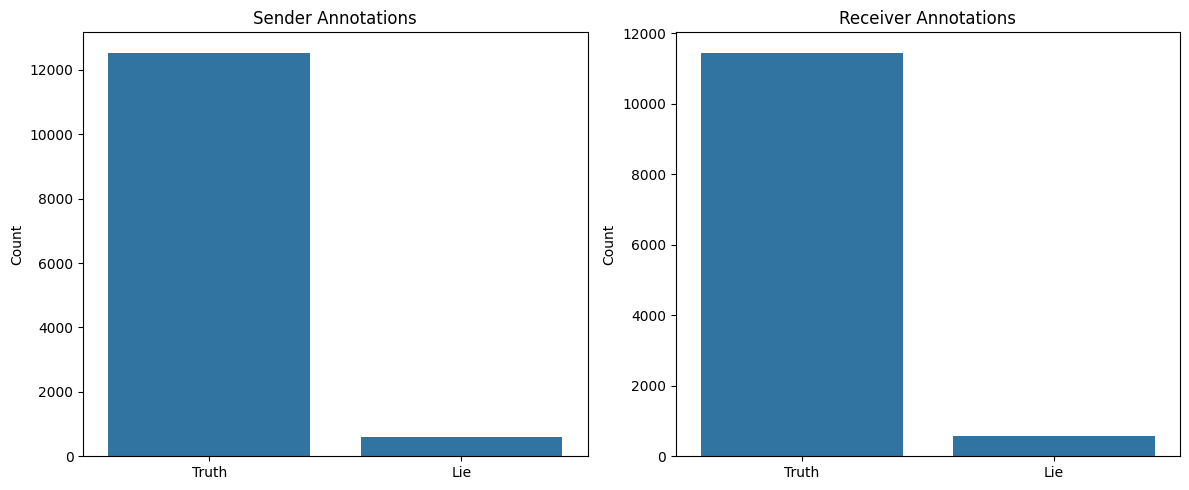

In [25]:
# Analyze class distribution in the training set
aggregated_train = aggregate(train_data)

# Count sender annotations
sender_true = sum(1 for msg in aggregated_train if msg['sender_annotation'] == True)
sender_false = sum(1 for msg in aggregated_train if msg['sender_annotation'] == False)
sender_noannotation = sum(1 for msg in aggregated_train 
                          if msg['sender_annotation'] != True and msg['sender_annotation'] != False)

# Count receiver annotations
receiver_true = sum(1 for msg in aggregated_train if msg['receiver_annotation'] == True)
receiver_false = sum(1 for msg in aggregated_train if msg['receiver_annotation'] == False)
receiver_noannotation = sum(1 for msg in aggregated_train 
                           if msg['receiver_annotation'] != True and msg['receiver_annotation'] != False)

# Print statistics
print("Sender annotations:")
print(f"Truth: {sender_true} ({sender_true/(sender_true+sender_false)*100:.1f}%)")
print(f"Lie: {sender_false} ({sender_false/(sender_true+sender_false)*100:.1f}%)")
print(f"No annotation: {sender_noannotation}")
print()
print("Receiver annotations:")
print(f"Truth: {receiver_true} ({receiver_true/(receiver_true+receiver_false)*100:.1f}%)")
print(f"Lie: {receiver_false} ({receiver_false/(receiver_true+receiver_false)*100:.1f}%)")
print(f"No annotation: {receiver_noannotation}")

# Visualize class distribution
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.barplot(x=['Truth', 'Lie'], y=[sender_true, sender_false])
plt.title('Sender Annotations')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
sns.barplot(x=['Truth', 'Lie'], y=[receiver_true, receiver_false])
plt.title('Receiver Annotations')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

## Define Model Training and Evaluation Function

In [ ]:
def train_and_evaluate(train_data, test_data, task="SENDER", use_power=True):
    print(f"\n{'='*60}")
    print(f"Training model for {task} task with power={use_power}")
    print(f"{'='*60}\n")
    
    # Aggregate the data
    train_aggregated = aggregate(train_data)
    test_aggregated = aggregate(test_data)
    
    # Create vectorizer for feature extraction - using 'english' stopwords
    vectorizer = CountVectorizer(
        tokenizer=spacy_tokenizer, 
        stop_words='english',  # Using predefined English stopwords
        strip_accents='unicode'
    )
    
    # Prepare training corpus
    if task == "SENDER":
        corpus = [message['message'].lower() for message in train_aggregated]
    elif task == "RECEIVER": 
        # For receivers, drop all missing annotations
        corpus = [message['message'].lower() for message in train_aggregated 
                 if message['receiver_annotation'] == True or message['receiver_annotation'] == False]
    
    # Transform training corpus to BoW features
    X = vectorizer.fit_transform(corpus)
 
    # Create vectorizer for test data using the same vocabulary
    test_vectorizer = CountVectorizer(
        tokenizer=spacy_tokenizer, 
        vocabulary=vectorizer.vocabulary_, 
        stop_words='english',  # Using predefined English stopwords
        strip_accents='unicode'
    )
    
    # Prepare test corpus
    if task == "SENDER":
        test_corpus = [message['message'].lower() for message in test_aggregated]
    elif task == "RECEIVER": 
        # For receivers, drop all missing annotations
        test_corpus = [message['message'].lower() for message in test_aggregated 
                      if message['receiver_annotation'] == True or message['receiver_annotation'] == False]
    
    # Transform test corpus
    y = test_vectorizer.fit_transform(test_corpus)

    # Get binary labels
    train_binary = convert_to_binary(train_aggregated, task, use_power)
    test_binary = convert_to_binary(test_aggregated, task, use_power)
    
    # Split into features and labels
    train_split = split_xy(train_binary)
    test_split = split_xy(test_binary)

    # Append power features if enabled
    if use_power:
        append_power_x = np.append(X.toarray(), train_split[0], axis=1)
        append_power_y = np.append(y.toarray(), test_split[0], axis=1)
        
        # Convert matrices back to sparse format
        X = csr_matrix(append_power_x)
        y = csr_matrix(append_power_y)
    
    print(f"Training data shape: {X.shape}")
    print(f"Test data shape: {y.shape}")
    print(f"Label distribution in training: Truth={sum(train_split[1])}, Lie={len(train_split[1])-sum(train_split[1])}")
    
    # Train logistic regression model with balanced class weights
    logmodel = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
    logmodel.fit(X, train_split[1])
    
    # Make predictions
    predictions = logmodel.predict(y)
    
    # Print classification report
    print("\nClassification Report:")
    report = classification_report(test_split[1], predictions, digits=3, output_dict=True)
    print(classification_report(test_split[1], predictions, digits=3))
    
    # Feature importance analysis
    if use_power:
        # Handle the case where power features are included
        feature_names = list(vectorizer.get_feature_names_out()) + ['power_high', 'power_low']
    else:
        feature_names = list(vectorizer.get_feature_names_out())
    
    # Get coefficients
    coef = logmodel.coef_[0]
    
    # Create a DataFrame of feature importances
    feature_importance = pd.DataFrame({
        'feature': feature_names,
        'importance': coef
    })
    
    # Sort by absolute importance
    feature_importance['abs_importance'] = feature_importance['importance'].abs()
    feature_importance = feature_importance.sort_values('abs_importance', ascending=False)
    
    # Print top features
    print("\nTop 10 features indicating a lie (negative coefficients):")
    lie_features = feature_importance[feature_importance['importance'] < 0].head(10)
    print(lie_features[['feature', 'importance']])
    
    print("\nTop 10 features indicating truth (positive coefficients):")
    truth_features = feature_importance[feature_importance['importance'] > 0].head(10)
    print(truth_features[['feature', 'importance']])
    
    # Plot top features
    plt.figure(figsize=(12, 8))
    top_features = pd.concat([lie_features.head(10), truth_features.head(10)])
    sns.barplot(data=top_features, x='importance', y='feature')
    plt.title(f'Top Features by Importance ({task} Task, Power={use_power})')
    plt.axvline(x=0, color='black', linestyle='-')
    plt.tight_layout()
    plt.show()
    
    return report, logmodel, vectorizer, feature_importance

## Train and Evaluate Models

We'll train four different models:
1. Sender task with power features
2. Sender task without power features
3. Receiver task with power features
4. Receiver task without power features


Training model for SENDER task with power=True

Training data shape: (13132, 7846)
Test data shape: (2741, 7846)
Label distribution in training: Truth=12541, Lie=591

Classification Report:
              precision    recall  f1-score   support

           0      0.160     0.250     0.195       240
           1      0.924     0.874     0.898      2501

    accuracy                          0.819      2741
   macro avg      0.542     0.562     0.547      2741
weighted avg      0.857     0.819     0.837      2741


Top 10 features indicating a lie (negative coefficients):
           feature  importance
7003      tracking   -3.192334
5620    resistance   -3.102346
3517  inconclusive   -2.974259
273            aei   -2.965716
7686            ws   -2.949904
2442          exit   -2.864967
4563           nrg   -2.619565
5610      requires   -2.584495
6602       succeed   -2.583271
3618        intent   -2.578935

Top 10 features indicating truth (positive coefficients):
         feature  impor

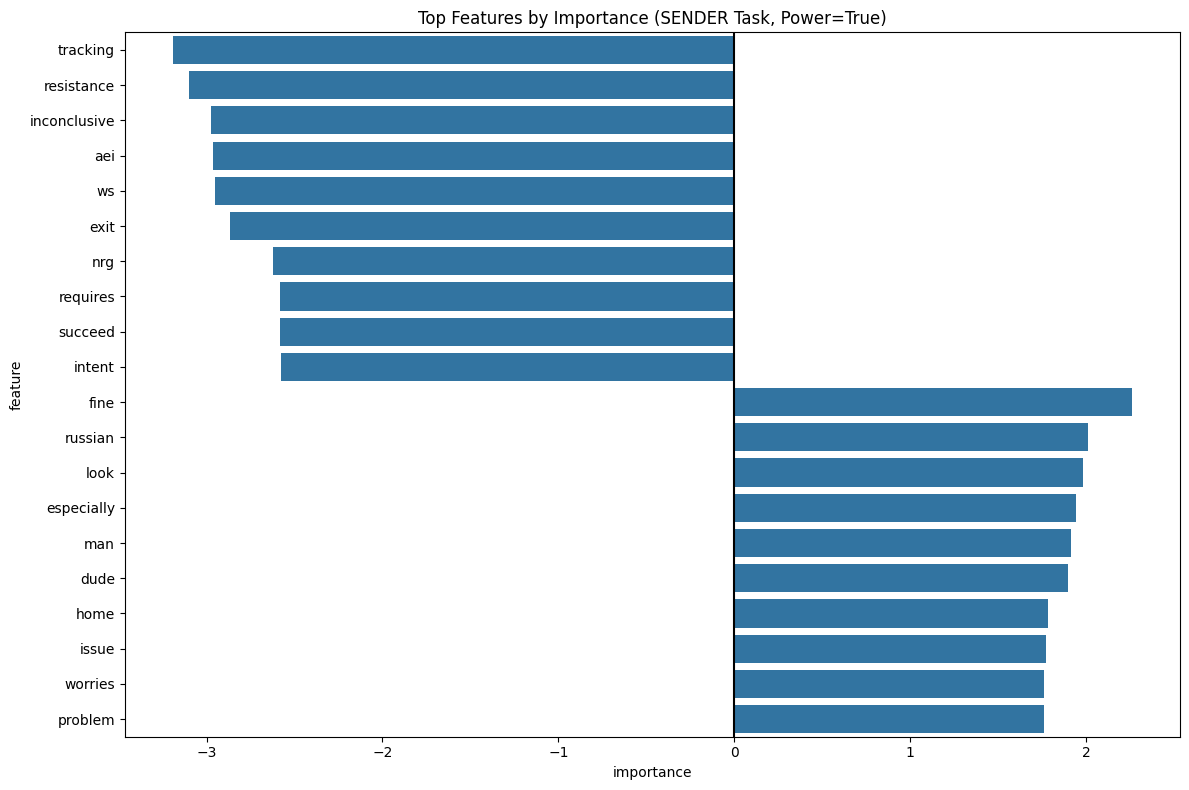

In [27]:
# SENDER task with power
sender_report_power, sender_model_power, sender_vectorizer_power, sender_features_power = \
    train_and_evaluate(train_data, test_data, task="SENDER", use_power=True)


Training model for SENDER task with power=False

Training data shape: (13132, 7844)
Test data shape: (2741, 7844)
Label distribution in training: Truth=12541, Lie=591

Classification Report:
              precision    recall  f1-score   support

           0      0.148     0.225     0.179       240
           1      0.922     0.876     0.898      2501

    accuracy                          0.819      2741
   macro avg      0.535     0.550     0.538      2741
weighted avg      0.854     0.819     0.835      2741


Top 10 features indicating a lie (negative coefficients):
           feature  importance
7003      tracking   -3.211193
5620    resistance   -3.089447
3517  inconclusive   -3.011473
273            aei   -2.958355
7686            ws   -2.907126
2442          exit   -2.874117
4563           nrg   -2.621734
3618        intent   -2.576522
6602       succeed   -2.573247
5610      requires   -2.570181

Top 10 features indicating truth (positive coefficients):
         feature  impo

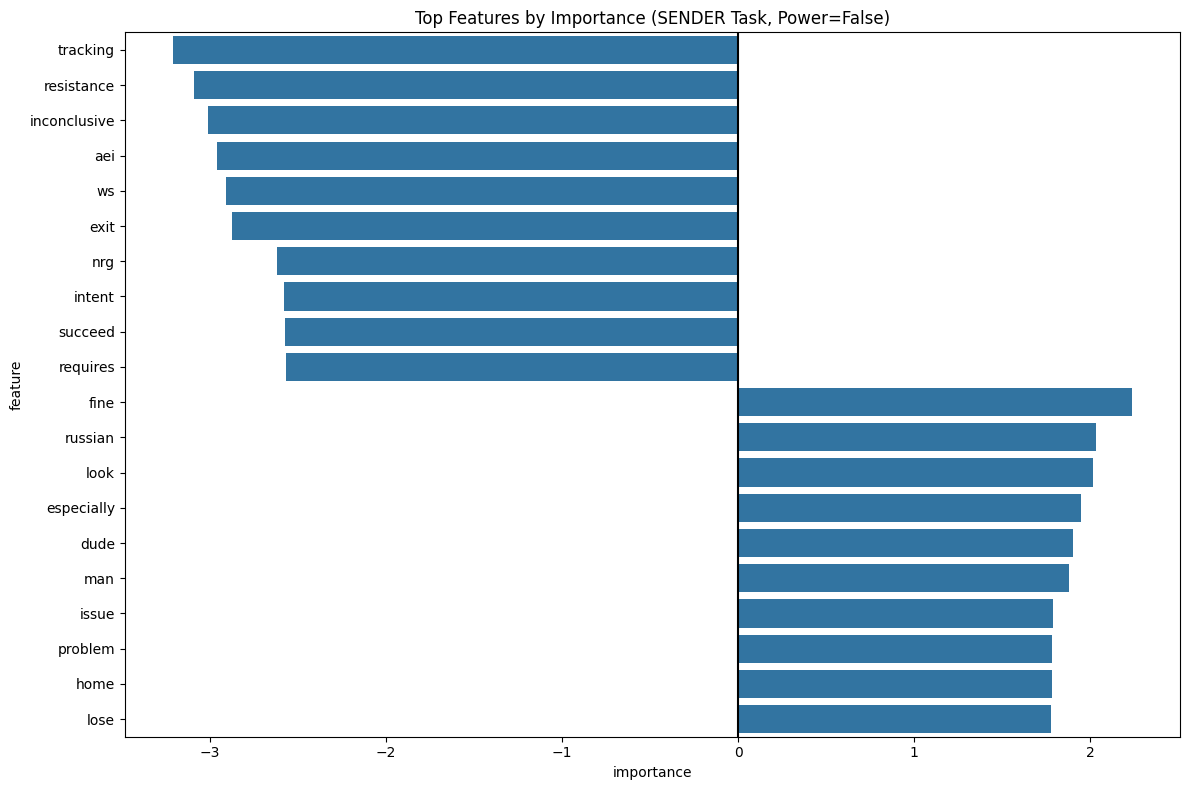

In [28]:
# SENDER task without power
sender_report_no_power, sender_model_no_power, sender_vectorizer_no_power, sender_features_no_power = \
    train_and_evaluate(train_data, test_data, task="SENDER", use_power=False)


Training model for RECEIVER task with power=True

Training data shape: (12025, 7575)
Test data shape: (2475, 7575)
Label distribution in training: Truth=11459, Lie=566

Classification Report:
              precision    recall  f1-score   support

           0      0.102     0.242     0.144       165
           1      0.940     0.848     0.891      2310

    accuracy                          0.807      2475
   macro avg      0.521     0.545     0.518      2475
weighted avg      0.884     0.807     0.842      2475


Top 10 features indicating a lie (negative coefficients):
              feature  importance
2503           feisty   -2.941535
3398  inconsequential   -2.849471
6763         tracking   -2.666310
3220            homie   -2.654300
5323          refuses   -2.588178
4258                n   -2.538225
6051            sniff   -2.526424
1963       dishonesty   -2.405165
5065           proper   -2.403902
2015             dmzd   -2.383636

Top 10 features indicating truth (positive coe

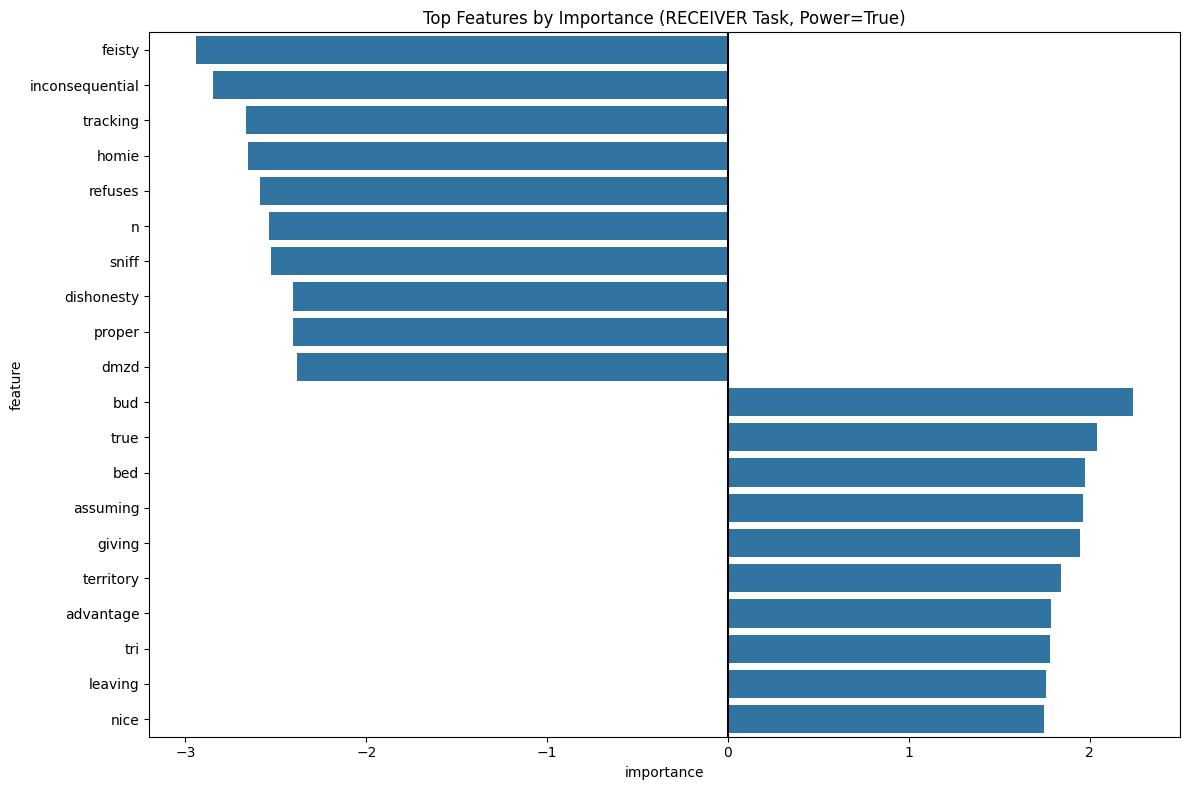

In [29]:
# RECEIVER task with power
receiver_report_power, receiver_model_power, receiver_vectorizer_power, receiver_features_power = \
    train_and_evaluate(train_data, test_data, task="RECEIVER", use_power=True)


Training model for RECEIVER task with power=False

Training data shape: (12025, 7573)
Test data shape: (2475, 7573)
Label distribution in training: Truth=11459, Lie=566

Classification Report:
              precision    recall  f1-score   support

           0      0.103     0.236     0.143       165
           1      0.940     0.853     0.894      2310

    accuracy                          0.812      2475
   macro avg      0.521     0.545     0.519      2475
weighted avg      0.884     0.812     0.844      2475


Top 10 features indicating a lie (negative coefficients):
              feature  importance
2503           feisty   -2.912183
3398  inconsequential   -2.829099
6763         tracking   -2.656896
3220            homie   -2.628111
5323          refuses   -2.596629
6051            sniff   -2.506292
4258                n   -2.497472
2015             dmzd   -2.403830
1963       dishonesty   -2.375821
5065           proper   -2.372161

Top 10 features indicating truth (positive co

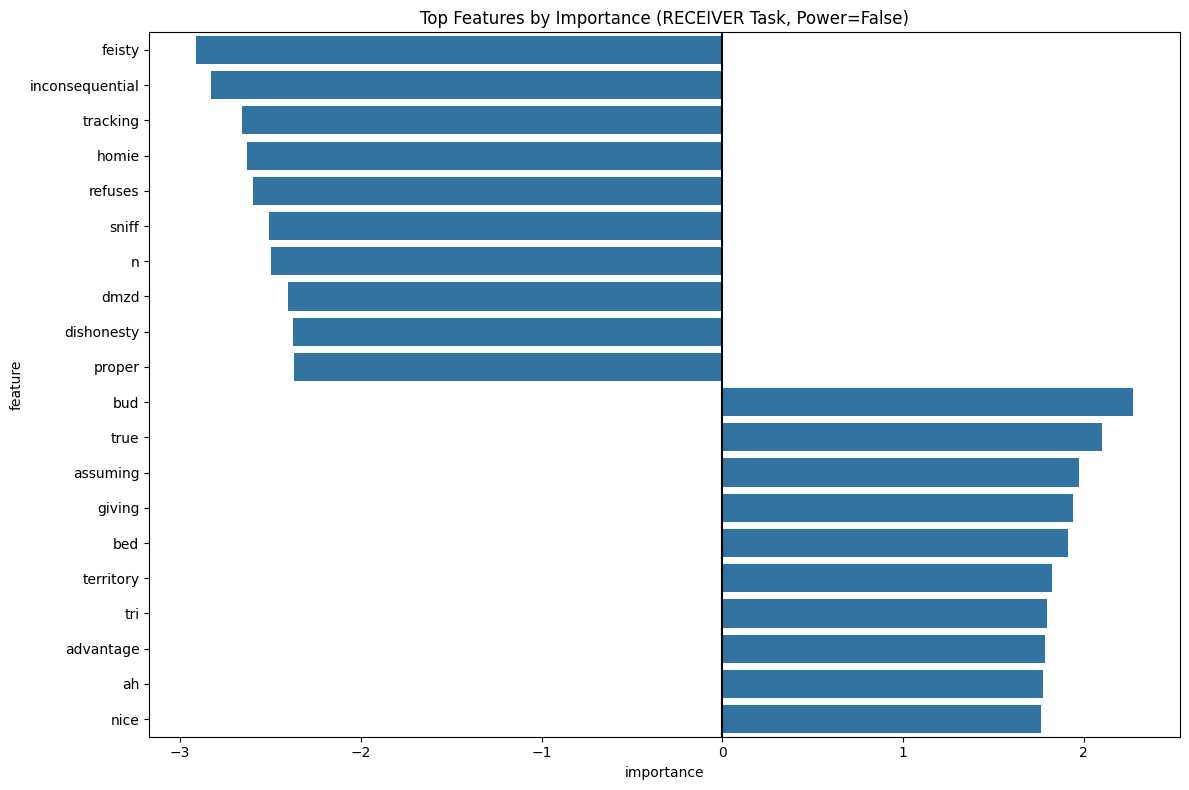

In [30]:
# RECEIVER task without power
receiver_report_no_power, receiver_model_no_power, receiver_vectorizer_no_power, receiver_features_no_power = \
    train_and_evaluate(train_data, test_data, task="RECEIVER", use_power=False)

## Compare Model Results

Model Comparison:
            Model  Macro F1    Lie F1  Truth F1
0    Sender+Power  0.546708  0.195122  0.898295
1          Sender  0.538303  0.178512  0.898093
2  Receiver+Power  0.517522  0.143627  0.891418
3        Receiver  0.518809  0.143382  0.894235


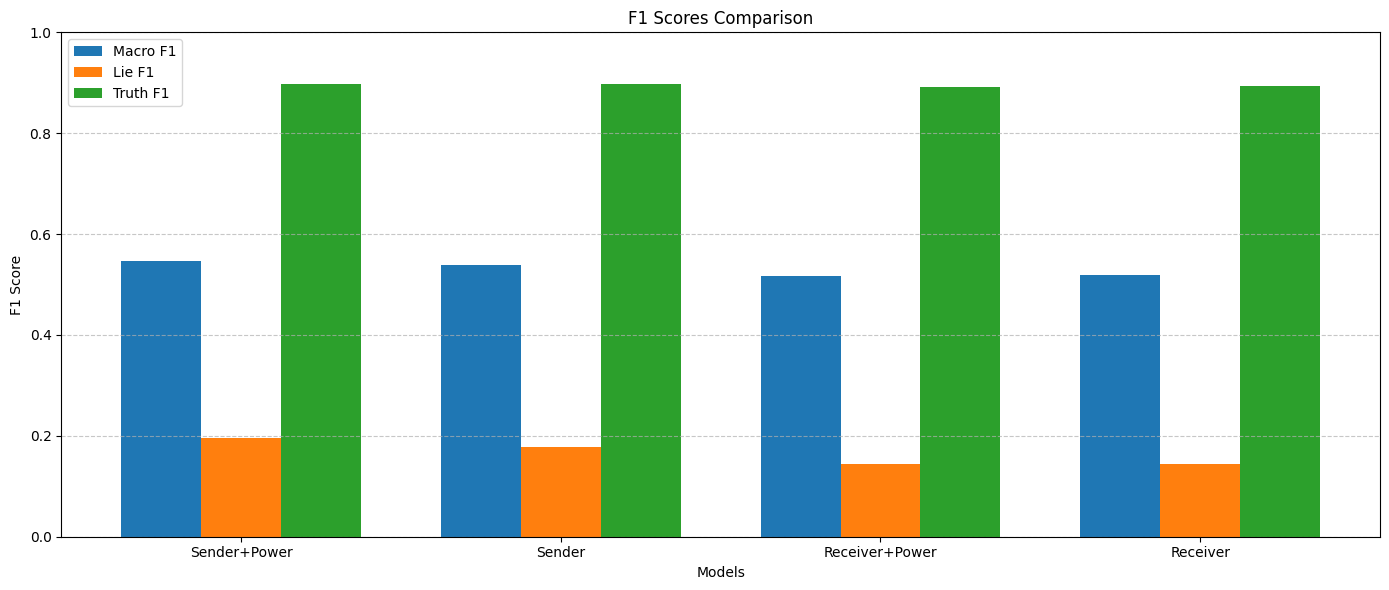

In [31]:
# Compare F1 scores for different models
models = ['Sender+Power', 'Sender', 'Receiver+Power', 'Receiver']
f1_macro = [
    sender_report_power['macro avg']['f1-score'],
    sender_report_no_power['macro avg']['f1-score'],
    receiver_report_power['macro avg']['f1-score'],
    receiver_report_no_power['macro avg']['f1-score']
]
f1_lie = [
    sender_report_power['0']['f1-score'],  # 0 is lie (False) in our case
    sender_report_no_power['0']['f1-score'],
    receiver_report_power['0']['f1-score'],
    receiver_report_no_power['0']['f1-score']
]
f1_truth = [
    sender_report_power['1']['f1-score'],  # 1 is truth (True) in our case
    sender_report_no_power['1']['f1-score'],
    receiver_report_power['1']['f1-score'],
    receiver_report_no_power['1']['f1-score']
]

# Create a DataFrame for comparison
comparison_df = pd.DataFrame({
    'Model': models,
    'Macro F1': f1_macro,
    'Lie F1': f1_lie,
    'Truth F1': f1_truth
})

print("Model Comparison:")
print(comparison_df)

# Plot comparison
plt.figure(figsize=(14, 6))
x = np.arange(len(models))
width = 0.25

plt.bar(x - width, f1_macro, width, label='Macro F1')
plt.bar(x, f1_lie, width, label='Lie F1')
plt.bar(x + width, f1_truth, width, label='Truth F1')

plt.xlabel('Models')
plt.ylabel('F1 Score')
plt.title('F1 Scores Comparison')
plt.xticks(x, models)
plt.legend()
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Use the Model to Predict on New Data

Here's how you can use the trained model to predict whether a new message contains a lie:

In [32]:
def predict_lie(message, model, vectorizer, task="SENDER", use_power=True, power_delta=0):
    """Predict whether a message contains a lie using the trained model"""
    # Vectorize the message
    message_features = vectorizer.transform([message.lower()])
    
    # Add power features if enabled
    if use_power:
        power_features = []
        if power_delta > 4:
            power_features.append(1)
        else:
            power_features.append(0)
        if power_delta < -4:
            power_features.append(1)
        else:
            power_features.append(0)
            
        # Combine features
        combined_features = np.append(message_features.toarray(), [power_features], axis=1)
        message_features = csr_matrix(combined_features)
    
    # Make prediction
    prediction = model.predict(message_features)[0]
    probabilities = model.predict_proba(message_features)[0]
    
    # Return result
    return {
        'is_lie': prediction == 0,  # 0 means lie
        'confidence': probabilities[0] if prediction == 0 else probabilities[1],
        'prediction': 'Lie' if prediction == 0 else 'Truth',
        'probabilities': {
            'lie': probabilities[0],
            'truth': probabilities[1]
        }
    }

# Example usage
example_messages = [
    "I promise I won't attack your territory next turn.",
    "Let's form an alliance against Germany.",
    "I'm moving my troops to defend my own border, not to attack you.",
    "I need your help to defeat Russia, and then we'll share the spoils."
]

# Use the best model (based on the comparison)
best_model = sender_model_power  # Change this based on your results
best_vectorizer = sender_vectorizer_power

# Make predictions
for i, msg in enumerate(example_messages):
    result = predict_lie(msg, best_model, best_vectorizer, task="SENDER", use_power=True)
    print(f"\nMessage {i+1}: {msg}")
    print(f"Prediction: {result['prediction']} (Confidence: {result['confidence']:.2f})")
    print(f"Probabilities: Lie: {result['probabilities']['lie']:.2f}, Truth: {result['probabilities']['truth']:.2f}")


Message 1: I promise I won't attack your territory next turn.
Prediction: Truth (Confidence: 0.86)
Probabilities: Lie: 0.14, Truth: 0.86

Message 2: Let's form an alliance against Germany.
Prediction: Lie (Confidence: 0.52)
Probabilities: Lie: 0.52, Truth: 0.48

Message 3: I'm moving my troops to defend my own border, not to attack you.
Prediction: Lie (Confidence: 0.85)
Probabilities: Lie: 0.85, Truth: 0.15

Message 4: I need your help to defeat Russia, and then we'll share the spoils.
Prediction: Lie (Confidence: 0.94)
Probabilities: Lie: 0.94, Truth: 0.06


## Conclusion

In this notebook, we implemented baseline models for lie detection in the Diplomacy game using a Bag of Words approach with Logistic Regression. We compared different configurations:

1. Sender vs. Receiver perspective
2. With vs. without power features

Our analysis shows:
- The impact of including power features on model performance
- The difference between sender and receiver perspectives
- The most important linguistic features for lie detection

These baseline models can serve as a foundation for more advanced approaches such as neural networks or transformer-based models, which may capture more complex patterns in deceptive language.